# Cross-Validation plots (Figure 4)

## Before you start

This notebook assumes that the cross-validation analyses, up to and including `evaluate_errors.sh` has already been run. 

Please refer to the `cross_validation` pipeline located in `scripts/cross_validation`, or download the analysis from Zenodo (https://doi.org/10.5281/zenodo.8006854).

The data are expected to be located in the directory `../datasets/gibson/healthy/cross_validation` for healthy cohort and `../datasets/gibson/uc/cross_validation` for dysbiotic cohort runs.

# Imports and plotting functions

In [1]:
from typing import *
from pathlib import Path
import numpy as np
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import itertools

import scipy.stats
from statsmodels.stats.multitest import fdrcorrection

from matplotlib.patches import Patch
import matplotlib.transforms as mtransforms
import string

# Make font editable in AI
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Path("plots").mkdir(exist_ok=True, parents=True)

In [2]:
def compute_pvalues(abund_df: pd.DataFrame):
    df_entries = []
    for (i1, m1), (i2, m2) in itertools.combinations(enumerate(method_order), 2):
        _x = abund_df.loc[abund_df['Method'] == m1, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])
        _y = abund_df.loc[abund_df['Method'] == m2, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])
        _merged = _x[['HeldoutSubjectIdx', 'TaxonIdx', 'Error']].merge(
            _y[['HeldoutSubjectIdx', 'TaxonIdx', 'Error']],
            on=['HeldoutSubjectIdx', 'TaxonIdx'],
            how='outer',
            suffixes=['_1', '_2']
        )
        _x = _merged['Error_1'].to_numpy()
        _y = _merged['Error_2'].to_numpy()

        _k = (~np.isnan(_x)) & (~np.isnan(_y))
        _x = _x[_k]
        _y = _y[_k]

        if len(_x) == 0 or len(_y) == 0:
            continue

        _stat, _pval = scipy.stats.wilcoxon(_x, _y, alternative='two-sided')
        df_entries.append({
            'Method A': m1,
            'Method B': m2,
            'p': _pval,
            'WilcoxonStatistic': _stat
        })
    pval_df = pd.DataFrame(df_entries)
    
    # FDR correction.
    _, bh_pvals = fdrcorrection(pval_df['p'])
    pval_df['BHCorrectedp'] = bh_pvals
    return pval_df

In [3]:
def annot_pvalue(ax, pvalue, x1, x2, y, h, color='black', log_scale=False, text_label=None, fontsize: int = 5):
    # statistical annotation
    grid_x = np.array([x1, x1, x2, x2])
    grid_y = np.array([0.5*h, 1.5*h, 1.5*h, 0.5*h])
    if log_scale:
        grid_y = np.exp(np.log10(y) + grid_y)
    else:
        grid_y = y + grid_y
    ax.plot(grid_x, grid_y, lw=0.7, c=color)

    if text_label is not None:
        text_x = 0.5 * (x1 + x2)
        # text_y = grid_y[0]
        if log_scale:
            text_y = np.exp(np.log10(y) + 1.5 * h)
        else:
            text_y = y + 0.8 * h
        t = ax.text(
            text_x, text_y, text_label, ha='center', va='bottom', color=color, size=fontsize
        )

In [4]:
def make_boxplot(
    ax,
    df: pd.DataFrame,
    method_order: List[str],
    method_labels: Dict[str, str],
    method_colors: Dict[str, np.ndarray],
    lb: float,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    eps: float = 0.0,
    box_width: float = None,
):
    def agg_fn(_df):
        _df = _df.loc[_df['Truth'] > lb]
        truth = _df['Truth'].to_numpy() + eps
        pred = _df['Pred'].to_numpy() + eps

        err = np.sqrt(np.mean(np.square(
            np.log10(pred) - np.log10(truth)
        )))  # Root mean squared?
        
        return pd.Series({'Error': err}, index=['Error'])

    df = df.loc[df['Truth'] > lb, :]
    df = df.groupby(['Method', 'HeldoutSubjectIdx', 'TaxonIdx']).apply(agg_fn).reset_index()
    df = df.loc[
        df['Method'].isin(method_order)
    ].sort_values(
        by='Method',
        key=lambda col: col.map({m: i for i, m in enumerate(method_order)})
    )

    sns.boxplot(
        data=df,
        ax=ax,
        x='Method',
        y='Error',
        showfliers=False,
        palette=method_colors,
        whis=(2.5, 97.5),
        width=box_width,
        boxprops=dict(edgecolor='black', linewidth=1),         # Box outline
        medianprops=dict(color='black', linewidth=1),           # Median line
        whiskerprops=dict(color='black', linewidth=1),  # Whiskers
        capprops=dict(color='black', linewidth=1)            # Caps
    )
    # sns.stripplot(
    #     data=df,
    #     ax=ax,
    #     x='Method',
    #     y='Error',
    #     color='white', edgecolor='black', linewidth=1.0
    # )

    labels = [
        method_labels[item.get_text()]
        for item in ax.get_xticklabels()
    ]
    ax.set_xticklabels(labels, rotation=45, ha='right')

    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    ax.set_axisbelow(True)
    ax.yaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')

    # ============= Compute and Render PValues.
    pvalue_df = compute_pvalues(df)
    method_indices = {m: i for i, m in enumerate(method_order)}

    j = 0
    for idx, row in pvalue_df.iterrows():
        # only show non-sig
        if row['BHCorrectedp'] > 0.05:
            c = 'black'
            lbl = 'n.s.'
        else:
            continue
        # elif row['BHCorrectedp'] > 0.01:
        #     c = 'black'
        #     lbl = '*'
        # elif row['BHCorrectedp'] > 0.001:
        #     c = 'black'
        #     lbl = '**'
        # elif row['BHCorrectedp'] > 0.0001:
        #     c = 'black'
        #     lbl = '***'
        # else:
        #     c = 'black'
        #     lbl = '****'

        method1 = row['Method A']
        method2 = row['Method B']
        x1 = method_indices[method1]
        x2 = method_indices[method2]
        # y_annot = df['Error'].max()
        y_annot = np.quantile(df['Error'], q=0.975)
        annot_pvalue(ax, row['BHCorrectedp'], x1=x1, x2=x2, y=y_annot + 0.5 + 0.5 * (j), h=0.1, color=c, text_label=lbl, fontsize=10)
        j += 1 
    return df, pvalue_df

In [5]:
def make_grouped_boxplot(bin_ax, error_ax,
                         df,
                         method_order: List[str],
                         method_labels: Dict[str, str],
                         method_colors: Dict[str, np.ndarray],
                         lb: float,
                         num_bins: int = 10,
                         error_ylabel: Optional[str] = None,
                         eps: float = 0.0,
                         bin_xlabel: str = 'concentration'):
    def agg_fn(_df):
        truth = _df['Truth'].to_numpy() + eps
        pred = _df['Pred'].to_numpy() + eps

        err = np.sqrt(np.mean(np.square(
            np.log10(pred) - np.log10(truth)
        )))  # Root mean squared?

        _method = _df.head(1)['Method'].item()
        if np.isnan(err.item()):
            raise Exception("ASDF")
        return pd.Series({'Error': err}, index=['Error'])

    df = df.loc[df['Truth'] > lb]
    df = df.assign(Bin=pd.qcut(
        np.log10(df['Truth']),
        q=num_bins,
        duplicates='drop'
    ))
    df_agg = df.groupby(['Method', 'HeldoutSubjectIdx', 'TaxonIdx', 'Bin']).apply(agg_fn).reset_index()


    # ============ Render bin counts.
    def _aggregate_abundances_bin(_df):
        _bin = _df.head(1)['Bin'].item()
        count = sum(1 for _ in _df.groupby(['HeldoutSubjectIdx', 'TaxonIdx', 'TimePoint']))
        return pd.Series({
            'Left': _bin.left,
            'Right': _bin.right,
            'Count': count
        })
    bin_counts = df.groupby('Bin').apply(_aggregate_abundances_bin)
    widths = bin_counts['Right'] - bin_counts['Left']

    xmin = bin_counts['Left'].min()
    xmax = bin_counts['Right'].max()
    y = 0.0
    h = 0.5
    r = 0.7 * (2 * h)
    eps = 0.01

    bin_ax.set_xlim([xmin-eps, xmax+eps])
    bin_ax.set_ylim([y-h, y+h])
    boundaries = set()
    bin_indices = {}

    for b_idx, (_, row) in enumerate(bin_counts.iterrows()):
        x1 = row['Left']
        x2 = row['Right']
        boundaries.add(x1)
        boundaries.add(x2)
        bin_indices[x1] = b_idx

        xm = 0.5 * (x1 + x2)
        bin_ax.plot([x1, x2], [y, y], label='', color='black', linewidth=1.0, zorder=0)
        bin_ax.plot([x1, x1], [y - h, y + h], label='', color='black', linewidth=1.0, zorder=0)
        bin_ax.text(xm, y, f'{b_idx + 1}', ha='center', va='center', zorder=2, color='black', fontsize=8)

        x1 = row['Left']
        x2 = row['Right']
        xm = 0.5 * (x1 + x2)

        # calculate the aspect ratio
        xscale, yscale = bin_ax.transData.transform([1, 1]) - bin_ax.transData.transform([0, 0])

        radius_y = r
        radius_x = radius_y * yscale / xscale
        bin_ax.add_patch(patches.Ellipse((xm, y), radius_x, radius_y, color='white', alpha=1.0, zorder=1, linewidth=0.8, ec='black'))
    bin_ax.plot([xmax, xmax], [y - h, y + h], label='', color='black', linewidth=1.0, zorder=0)

    def sci_format(x):
        x = np.power(10, x)
        a, b = '{:.2E}'.format(x).split('E')
        return r'{:.1f}$ \times 10^{{{:1d}}}$'.format(float(a), int(b))

    boundaries = sorted(boundaries)
    bin_ax.set_yticks([])
    bin_ax.set_xticks(boundaries)
    bin_ax.set_xticklabels([sci_format(b) for b in boundaries], rotation=45, ha='right')
    bin_ax.set_xlabel(bin_xlabel)
    bin_ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    bin_ax.tick_params(length=0)


    # ============= Render RMSE.
    def _bin_label(interval):
        b_idx = bin_indices[interval.left]
        return f'{b_idx + 1}'
    df_agg['BinLabel'] = df_agg['Bin'].map(_bin_label)
    df_agg = df_agg.sort_values('Bin')
    supported_methods = set(pd.unique(df_agg['Method']))
    method_order = [m for m in method_order if m in supported_methods]
    sns.boxplot(
        data=df_agg,
        ax=error_ax,
        x='BinLabel',
        y='Error',
        hue='Method', hue_order=method_order, palette=method_colors,
        showfliers=False,
        whis=(2.5, 97.5)
    )
    error_ax.set_axisbelow(True)
    error_ax.yaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')
    error_ax.set_xlabel('Bin number')
    if error_ylabel is not None:
        error_ax.set_ylabel(error_ylabel)

    error_ax.get_legend().remove()

    # ============= Render PValues.
    bins = sorted(pd.unique(df_agg['Bin']))
    for bin_idx, _bin in enumerate(bins):
        bin_section = df_agg.loc[df_agg['Bin'] == _bin]

        # Compute p-values for each bin
        df_entries = []
        for (i1, m1), (i2, m2) in itertools.combinations(enumerate(method_order), 2):
            if not m1.startswith("MDSINE") and not m2.startswith("MDSINE"):
                continue
            _x = bin_section.loc[bin_section['Method'] == m1, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])['Error'].to_numpy()
            _y = bin_section.loc[bin_section['Method'] == m2, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])['Error'].to_numpy()
            _k = (~np.isnan(_x)) & (~np.isnan(_y))
            _x = _x[_k]
            _y = _y[_k]
            _stat, _pval = scipy.stats.wilcoxon(_x, _y, alternative='two-sided')
            df_entries.append({
                'Method1': m1,
                'Method2': m2,
                'i1': i1,
                'i2': i2,
                'p': _pval
            })
        pval_df = pd.DataFrame(df_entries)

        # ==== Dataframe with p-values (BH correction)
        y_annot = np.quantile(bin_section.dropna()['Error'], q=0.99)
        _, bh_pvals = fdrcorrection(pval_df['p'])
        pval_df['bh'] = bh_pvals

        # ==== p-value annotation render.
        j = 0
        box_width = 0.8 / len(method_order)
        left_x = bin_idx - 0.4
        for idx, row in pval_df.iterrows():
            if row['bh'] > 0.05:
                c = '#FA8072'
                lbl = 'ns'
            elif row['bh'] > 0.01:
                c = 'black'
                lbl = '*'
            elif row['bh'] > 0.001:
                c = 'black'
                lbl = '**'
            elif row['bh'] > 0.0001:
                c = 'black'
                lbl = '***'
            else:
                c = 'black'
                lbl = '****'

            x1 = left_x + (0.5 * box_width) + (row['i1'] * box_width)
            x2 = left_x + (0.5 * box_width) + (row['i2'] * box_width)
            annot_pvalue(error_ax, row['bh'], x1=x1, x2=x2, y=y_annot + 0.2 * (j), h=0.05, color=c, text_label=lbl)
            j += 1

def make_zeros_geometricmean_boxplot(ax,
                        df,
                        method_order: List[str],
                        method_labels: Dict[str, str],
                        method_colors: Dict[str, np.ndarray],
                        lb: float,
                        num_bins: int = 10,
                        error_ylabel: Optional[str] = None,
                        eps: float = 0.0,
                        annot_dy: float = 0.5,
                        annot_h: float = 0.5):
    def agg_fn(_df):
        truth = _df['Truth'].to_numpy() + eps
        pred = _df['Pred'].to_numpy() + eps

        # == geometric mean
        err = np.mean(np.log10(pred))
        return pd.Series({'Error': err}, index=['Error'])

    df = df.loc[df['Truth'] < lb]
    df_agg = df.groupby(['Method', 'HeldoutSubjectIdx', 'TaxonIdx']).apply(agg_fn).reset_index()
    supported_methods = set(pd.unique(df_agg['Method']))
    method_order = [m for m in method_order if m in supported_methods]
    df_agg = df_agg.loc[
        df_agg['Method'].isin(method_order)
    ].sort_values(
        by='Method',
        key=lambda col: col.map({m: i for i, m in enumerate(method_order)})
    )

    # ============= Render RMSE.
    sns.boxplot(
        data=df_agg,
        x='Method',
        ax=ax,
        y='Error',
        palette=method_colors,
        showfliers=False,
        whis=(2.5, 97.5)
    )
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')
    ax.set_xlabel('')
    if error_ylabel is not None:
        ax.set_ylabel(error_ylabel)

    labels = [
        method_labels[item.get_text()]
        for item in ax.get_xticklabels()
    ]
    ax.set_xticklabels(labels)

# Load metrics

In [6]:
healthy_base_dir = Path('../datasets/gibson/healthy/cross_validation')
healthy_abs_df = pd.concat([
    pd.read_csv(healthy_base_dir / "mdsine2-modules" / "absolute_cv.tsv", sep='\t').assign(Method="MDSINE2"),
    pd.read_csv(healthy_base_dir / "mdsine2-nomodules" / "absolute_cv.tsv", sep='\t').assign(Method="MDSINE2 (No Modules)"),
    pd.read_csv(healthy_base_dir / "mdsine2-noqpcr-modules" / "absolute_cv.tsv", sep='\t').assign(Method="RA-MDSINE2"),
    pd.read_csv(healthy_base_dir / "mdsine2-noqpcr-nomodules" / "absolute_cv.tsv", sep='\t').assign(Method="RA-MDSINE2 (No Modules)"),
    pd.read_csv(healthy_base_dir / "regression_clv_elastic_net" / "absolute_cv.tsv", sep='\t').assign(Method="cLV"),
    pd.read_csv(healthy_base_dir / "regression_glv-ra_ridge" / "absolute_cv.tsv", sep='\t').assign(Method="gLV-RA (ridge)"),
    pd.read_csv(healthy_base_dir / "regression_glv-ra_elastic_net" / "absolute_cv.tsv", sep='\t').assign(Method="gLV-RA (elastic net)"),
    pd.read_csv(healthy_base_dir / "regression_glv_ridge" / "absolute_cv.tsv", sep='\t').assign(Method="gLV (ridge)"),
    pd.read_csv(healthy_base_dir / "regression_glv_elastic_net" / "absolute_cv.tsv", sep='\t').assign(Method="gLV (elastic net)"),
    pd.read_csv(healthy_base_dir / "regression_lra_elastic_net" / "absolute_cv.tsv", sep='\t').assign(Method="LRA"),
])
healthy_rel_df = pd.concat([
    pd.read_csv(healthy_base_dir / "mdsine2-modules" / "relative_cv.tsv", sep='\t').assign(Method="MDSINE2"),
    pd.read_csv(healthy_base_dir / "mdsine2-nomodules" / "relative_cv.tsv", sep='\t').assign(Method="MDSINE2 (No Modules)"),
    pd.read_csv(healthy_base_dir / "mdsine2-noqpcr-modules" / "relative_cv.tsv", sep='\t').assign(Method="RA-MDSINE2"),
    pd.read_csv(healthy_base_dir / "mdsine2-noqpcr-nomodules" / "relative_cv.tsv", sep='\t').assign(Method="RA-MDSINE2 (No Modules)"),
    pd.read_csv(healthy_base_dir / "regression_clv_elastic_net" / "relative_cv.tsv", sep='\t').assign(Method="cLV"),
    pd.read_csv(healthy_base_dir / "regression_glv-ra_ridge" / "relative_cv.tsv", sep='\t').assign(Method="gLV-RA (ridge)"),
    pd.read_csv(healthy_base_dir / "regression_glv-ra_elastic_net" / "relative_cv.tsv", sep='\t').assign(Method="gLV-RA (elastic net)"),
    pd.read_csv(healthy_base_dir / "regression_glv_ridge" / "relative_cv.tsv", sep='\t').assign(Method="gLV (ridge)"),
    pd.read_csv(healthy_base_dir / "regression_glv_elastic_net" / "relative_cv.tsv", sep='\t').assign(Method="gLV (elastic net)"),
    pd.read_csv(healthy_base_dir / "regression_lra_elastic_net" / "relative_cv.tsv", sep='\t').assign(Method="LRA"),
])

uc_base_dir = Path('../datasets/gibson/uc/cross_validation')
uc_abs_df = pd.concat([
    pd.read_csv(uc_base_dir / "mdsine2-modules" / "absolute_cv.tsv", sep='\t').assign(Method="MDSINE2"),
    pd.read_csv(uc_base_dir / "mdsine2-nomodules" / "absolute_cv.tsv", sep='\t').assign(Method="MDSINE2 (No Modules)"),
    pd.read_csv(uc_base_dir / "mdsine2-noqpcr-modules" / "absolute_cv.tsv", sep='\t').assign(Method="RA-MDSINE2"),
    pd.read_csv(uc_base_dir / "mdsine2-noqpcr-nomodules" / "absolute_cv.tsv", sep='\t').assign(Method="RA-MDSINE2 (No Modules)"),
    pd.read_csv(uc_base_dir / "regression_clv_elastic_net" / "absolute_cv.tsv", sep='\t').assign(Method="cLV"),
    pd.read_csv(uc_base_dir / "regression_glv-ra_ridge" / "absolute_cv.tsv", sep='\t').assign(Method="gLV-RA (ridge)"),
    pd.read_csv(uc_base_dir / "regression_glv-ra_elastic_net" / "absolute_cv.tsv", sep='\t').assign(Method="gLV-RA (elastic net)"),
    pd.read_csv(uc_base_dir / "regression_glv_ridge" / "absolute_cv.tsv", sep='\t').assign(Method="gLV (ridge)"),
    pd.read_csv(uc_base_dir / "regression_glv_elastic_net" / "absolute_cv.tsv", sep='\t').assign(Method="gLV (elastic net)"),
    pd.read_csv(uc_base_dir / "regression_lra_elastic_net" / "absolute_cv.tsv", sep='\t').assign(Method="LRA"),
])
uc_rel_df = pd.concat([
    pd.read_csv(uc_base_dir / "mdsine2-modules" / "relative_cv.tsv", sep='\t').assign(Method="MDSINE2"),
    pd.read_csv(uc_base_dir / "mdsine2-nomodules" / "relative_cv.tsv", sep='\t').assign(Method="MDSINE2 (No Modules)"),
    pd.read_csv(uc_base_dir / "mdsine2-noqpcr-modules" / "relative_cv.tsv", sep='\t').assign(Method="RA-MDSINE2"),
    pd.read_csv(uc_base_dir / "mdsine2-noqpcr-nomodules" / "relative_cv.tsv", sep='\t').assign(Method="RA-MDSINE2 (No Modules)"),
    pd.read_csv(uc_base_dir / "regression_clv_elastic_net" / "relative_cv.tsv", sep='\t').assign(Method="cLV"),
    pd.read_csv(uc_base_dir / "regression_glv-ra_ridge" / "relative_cv.tsv", sep='\t').assign(Method="gLV-RA (ridge)"),
    pd.read_csv(uc_base_dir / "regression_glv-ra_elastic_net" / "relative_cv.tsv", sep='\t').assign(Method="gLV-RA (elastic net)"),
    pd.read_csv(uc_base_dir / "regression_glv_ridge" / "relative_cv.tsv", sep='\t').assign(Method="gLV (ridge)"),
    pd.read_csv(uc_base_dir / "regression_glv_elastic_net" / "relative_cv.tsv", sep='\t').assign(Method="gLV (elastic net)"),
    pd.read_csv(uc_base_dir / "regression_lra_elastic_net" / "relative_cv.tsv", sep='\t').assign(Method="LRA"),
])

In [7]:
table_dir = Path("tables/fig3_cv")
table_dir.mkdir(exist_ok=True, parents=True)

healthy_abs_df.to_csv(table_dir / "healthy_abs.tsv", sep="\t", index=False)
healthy_rel_df.to_csv(table_dir / "healthy_rel.tsv", sep="\t", index=False)
uc_abs_df.to_csv(table_dir / "uc_abs.tsv", sep="\t", index=False)
uc_rel_df.to_csv(table_dir / "uc_rel.tsv", sep="\t", index=False)

# Absolute abundance metrics

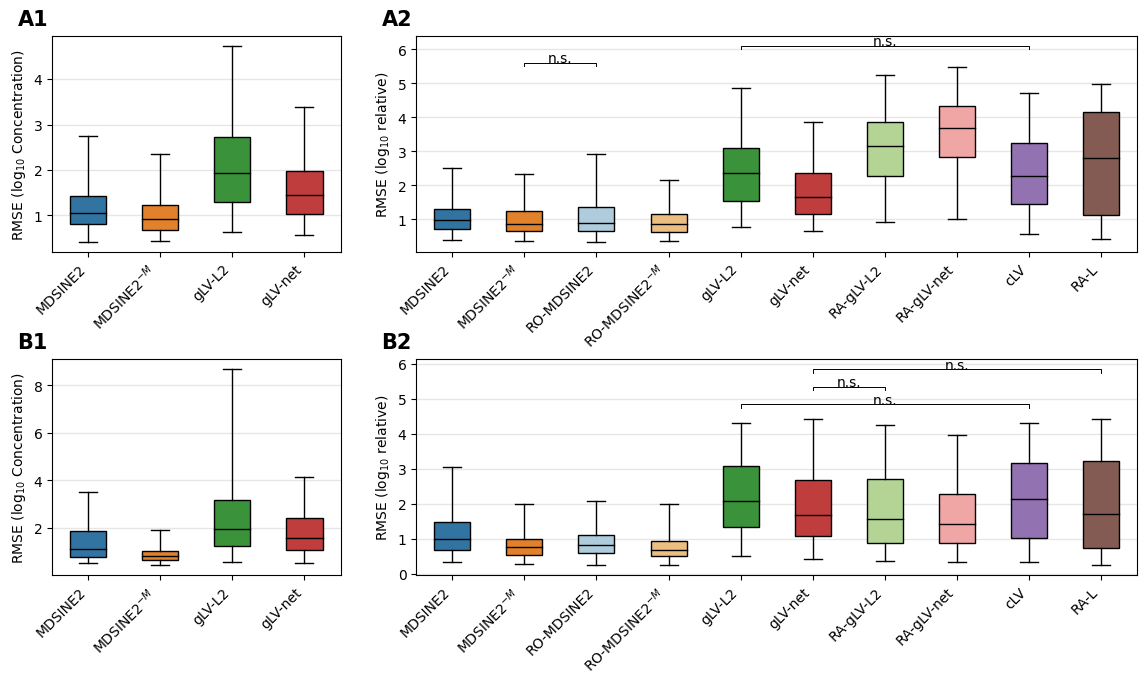

In [8]:
# method_order_all = ['MDSINE2', 'MDSINE2 (No Modules)', 'RA-MDSINE2', 'RA-MDSINE2 (No Modules)', 'gLV (ridge)', 'gLV (elastic net)', 'gLV-RA (ridge)', 'gLV-RA (elastic net)', 'cLV', 'LRA', 'MDSINE2_seed10']
method_labels = {
    'MDSINE2': 'MDSINE2', 
    'MDSINE2 (No Modules)': r'MDSINE$2^{-M}$',
    'RA-MDSINE2': 'RO-MDSINE2',
    'RA-MDSINE2 (No Modules)': 'RO-MDSINE$2^{-M}$',
    'cLV': 'cLV', 
    'gLV-RA (ridge)': 'RA-gLV-L2', 
    'gLV-RA (elastic net)': 'RA-gLV-net',
    'gLV (elastic net)': 'gLV-net', 
    'gLV (ridge)': 'gLV-L2', 
    'LRA': 'RA-L'
}
palette = sns.color_palette("tab10", n_colors=10)
paired_palette = sns.color_palette("Paired")
method_colors = {
    'MDSINE2': palette[0], 
    'MDSINE2 (No Modules)': palette[1], 
    'RA-MDSINE2': paired_palette[0], 
    'RA-MDSINE2 (No Modules)': paired_palette[6], 
    'gLV (ridge)': palette[2],
    'gLV (elastic net)': palette[3],
    'gLV-RA (elastic net)': paired_palette[4], 
    'gLV-RA (ridge)': paired_palette[2],
    'cLV': palette[4],
    'LRA': palette[5],
}
# paired_palette = sns.color_palette("Paired", 10)
# palette_tab20 = sns.color_palette("tab10", len(method_order_all))
# method_colors = {m: palette_tab20[i] for i, m in enumerate(method_order_all)}
# method_colors['RA-MDSINE2'] = paired_palette[0]
# method_colors['RA-MDSINE2 (No Modules)'] = paired_palette[6]


layout = [
    ["healthy_abs", "healthy_rel"],
    ["uc_abs", "uc_rel"],
]
ax_labels = {
    "healthy_abs": "A1",
    "healthy_rel": "A2",
    "uc_abs": "B1",
    "uc_rel": "B2",
}
fig, axes = plt.subplot_mosaic(
    layout, figsize=(14, 7),
    gridspec_kw={
        'height_ratios': [1, 1], 'width_ratios': [4, 10],
        'wspace': 0.15,
        'hspace': 0.5
    }
)
# Plot labels (A,B,C,D,etc)
for _k, _ax in axes.items():
    if _k not in ax_labels:
        continue
    trans = mtransforms.ScaledTranslation(-25/72, +5/72, fig.dpi_scale_trans)
    _ax.text(0, 1, ax_labels[_k], transform=_ax.transAxes + trans,
             va='bottom', fontfamily='sans-serif', weight='bold', size=15)

box_width = 0.5
lb = 1e-5
method_order = ['MDSINE2', 'MDSINE2 (No Modules)', 'gLV (ridge)', 'gLV (elastic net)']
healthy_abs_errors, healthy_abs_errors_pvals = make_boxplot(axes['healthy_abs'], healthy_abs_df, method_order, method_labels, method_colors, xlabel='', ylabel=r'RMSE ($\log_{10}$ Concentration)', lb=lb, eps=1e3, box_width=0.5)

lb = 1e-10
method_order = ['MDSINE2', 'MDSINE2 (No Modules)', 'RA-MDSINE2', 'RA-MDSINE2 (No Modules)', 'gLV (ridge)', 'gLV (elastic net)', 'gLV-RA (ridge)', 'gLV-RA (elastic net)', 'cLV', 'LRA']
healthy_rel_errors, healthy_rel_errors_pvals = make_boxplot(axes['healthy_rel'], healthy_rel_df, method_order, method_labels, method_colors, xlabel='', ylabel='RMSE ($\log_{10}$ relative)', lb=lb, eps=1e-8, box_width=box_width)

lb = 1e-5
method_order = ['MDSINE2', 'MDSINE2 (No Modules)', 'gLV (ridge)', 'gLV (elastic net)']
uc_abs_errors, uc_abs_errors_pvals = make_boxplot(axes['uc_abs'], uc_abs_df, method_order, method_labels, method_colors, xlabel='', ylabel=r'RMSE ($\log_{10}$ Concentration)', lb=lb, eps=1e3, box_width=box_width)

lb = 1e-10
method_order = ['MDSINE2', 'MDSINE2 (No Modules)', 'RA-MDSINE2', 'RA-MDSINE2 (No Modules)', 'gLV (ridge)', 'gLV (elastic net)', 'gLV-RA (ridge)', 'gLV-RA (elastic net)', 'cLV', 'LRA']
uc_rel_errors, uc_rel_errors_pvals = make_boxplot(axes['uc_rel'], uc_rel_df, method_order, method_labels, method_colors, xlabel='', ylabel='RMSE ($\log_{10}$ relative)', lb=lb, eps=1e-8, box_width=box_width)


# _uc_plot_df = make_boxplot(ax[0], abs_df, method_order, method_labels, method_colors, xlabel='', ylabel=r'RMSE ($\log_{10}$ Concentration)', lb=lb)
# make_grouped_boxplot(ax[1], ax[2], abs_df, method_order, method_labels, method_colors, num_bins=num_bins, error_ylabel='RMSE ($\log_{10}$ Concentration)', lb=lb)

# legend_elements = [
#     Patch(facecolor=method_colors[_m], edgecolor='black', label=method_labels[_m], linewidth=0.5)
#     for _m in method_order
# ]
# axes['legend'].axis("off")
# axes['legend'].legend(handles=legend_elements, ncol=5, bbox_to_anchor=(0.5, 1.0), loc='upper center', title='Evaluated Methods')

plt.savefig("plots/cv_healthy_and_uc.pdf", bbox_inches='tight', format='pdf')

In [9]:
healthy_abs_errors_pvals.to_csv("plots/cv_healthy_abs_pvals.tsv", sep='\t', index=False)
healthy_rel_errors_pvals.to_csv("plots/cv_healthy_rel_pvals.tsv", sep='\t', index=False)
uc_abs_errors_pvals.to_csv("plots/cv_uc_abs_pvals.tsv", sep='\t', index=False)
uc_rel_errors_pvals.to_csv("plots/cv_uc_rel_pvals.tsv", sep='\t', index=False)